In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial.distance import pdist, squareform
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
from vat import VAT

ImportError: cannot import name 'VAT' from 'vat' (/opt/anaconda3/lib/python3.11/site-packages/vat/__init__.py)

In [2]:
df = pd.read_csv('lowquality_final_merged.csv')
data = df.dropna()
data.reset_index(drop=True, inplace=True)

# Select relevant features
features = data[['User-ID', 'Book-Author-Encode', 'Book-Publisher-Encode', 'Book-Rating']]

# Aggregate data to create user profiles
user_profiles = features.groupby('User-ID').agg({
    'Book-Author-Encode': lambda x: x.mode()[0],  # Most frequent author
    'Book-Publisher-Encode': lambda x: x.mode()[0],  # Most frequent publisher
    'Book-Rating': 'mean'  # Average rating
}).reset_index()

In [3]:
data

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Book-Publisher,Year-Of-Publication-Bin,Book-Author-Encode,Book-Publisher-Encode,Year-Of-Publication-Bin-Encode,Filtered-Title,User-City,User-State,User-Country,User-Age,User-Age-Bin,User-City_Encoded,User-State_Encoded,User-Country_Encoded
0,276744,038550120X,7,painted house,JOHN GRISHAM,2001,Doubleday,"[2000, 2020)",2556,325,5,painted house,torrance,california,usa,-1,others,8447,5,6
1,16877,038550120X,9,painted house,JOHN GRISHAM,2001,Doubleday,"[2000, 2020)",2556,325,5,painted house,houston,others,usa,37,20~40,3767,23,6
2,16877,0743211383,3,dreamcatcher,Stephen King,2001,Scribner,"[2000, 2020)",5762,1062,5,dreamcatcher,houston,others,usa,37,20~40,3767,23,6
3,16877,0786868716,10,five people meet heaven,Mitch Albom,2003,Hyperion,"[2000, 2020)",4496,579,5,five people meet heaven,houston,others,usa,37,20~40,3767,23,6
4,16877,034539657X,7,dark river heart,Dean R. Koontz,1995,Ballantine Books,"[1980, 2000)",1417,111,4,dark river heart,houston,others,usa,37,20~40,3767,23,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89052,274167,1552781879,2,sanctuary,Lisa Appignanesi,2004,McArthur & Company,"[2000, 2020)",3826,729,5,sanctuary,whitehorse,others,canada,52,40~60,9157,23,1
89053,275387,0671024396,9,umbrella conspiracy resident evil,S.D. Perry,1998,Pocket,"[1980, 2000)",5467,913,4,umbrella conspiracy resident evil,new lenox,others,usa,19,0~20,5760,23,6
89054,275489,0671744062,7,firebrand,Marion Zimmer Bradley,1991,Pocket,"[1980, 2000)",4151,913,4,firebrand,hayward,california,usa,-1,others,3509,5,6
89055,276430,0758205589,10,get vibe,Kelly James-Enger,2003,STRAPLESS,"[2000, 2020)",3495,1029,5,get vibe,fayetteville,others,usa,40,20~40,2675,23,6


In [4]:
# Initialize a scaler
scaler = StandardScaler()

# Fit and transform the data
scaled_features = scaler.fit_transform(user_profiles[['Book-Author-Encode', 'Book-Publisher-Encode', 'Book-Rating']])


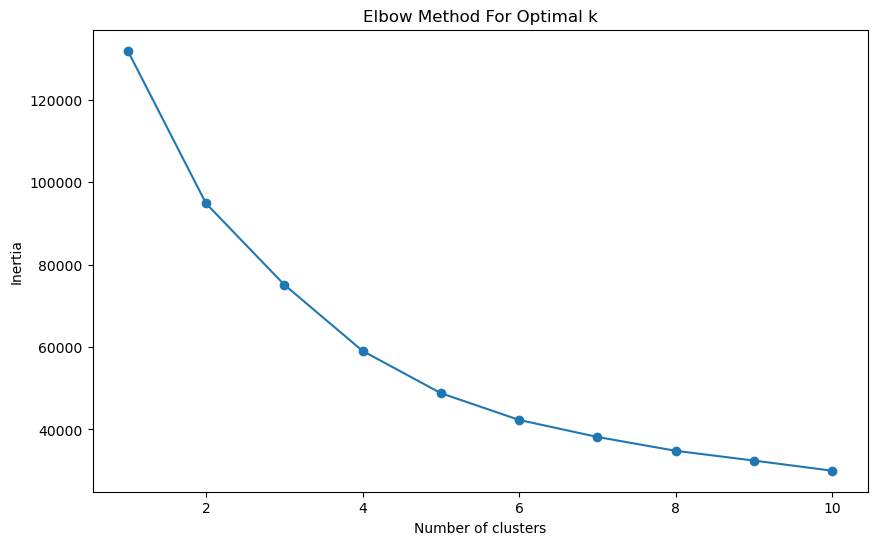

In [5]:
# Elbow method
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, n_init = 10, random_state=1)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

In [6]:
# Assuming the elbow is at k=3
kmeans = KMeans(n_clusters=3, n_init = 10, random_state=1)
clusters = kmeans.fit_predict(scaled_features)

# Add clusters back to the original data
user_profiles['Cluster'] = clusters

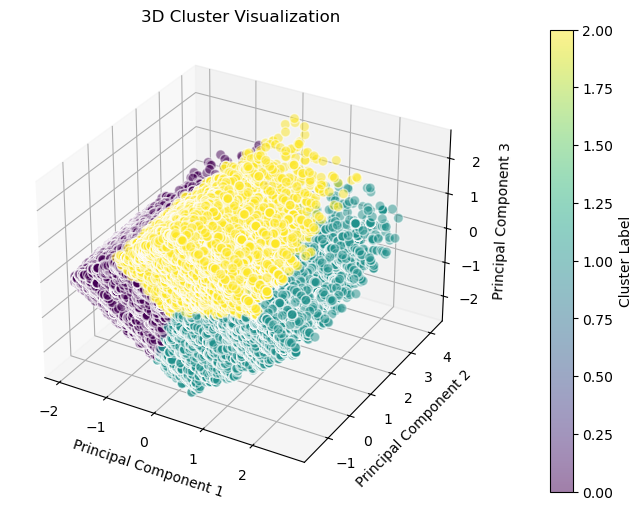

         Book-Author-Encode  Book-Publisher-Encode  Book-Rating
Cluster                                                        
0                      3079                    111     7.531654
1                      5762                    913     7.519749
2                      2694                    913     7.724325


In [7]:
# Visualize clusters in 3D
pca = PCA(n_components=3)
principal_components = pca.fit_transform(scaled_features)
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(principal_components[:, 0], 
                     principal_components[:, 1], 
                     principal_components[:, 2], 
                     c=clusters, s=50, cmap='viridis', alpha=0.5, edgecolors='w')

# Labeling axes
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')

# Adding a color bar to understand which color represents which cluster
color_bar = fig.colorbar(scatter, ax=ax, pad=0.1)
color_bar.set_label('Cluster Label')

# Setting title
ax.set_title('3D Cluster Visualization')

# Show plot
plt.show()

# Cluster Profiles
cluster_profiles = user_profiles.groupby('Cluster').agg({
    'Book-Author-Encode': lambda x: x.mode()[0],
    'Book-Publisher-Encode': lambda x: x.mode()[0],
    'Book-Rating': 'mean'
})
print(cluster_profiles)

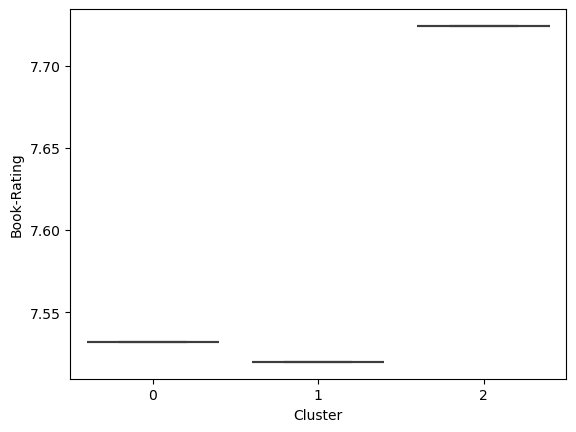

In [8]:
cluster_profiles['Cluster'] = cluster_profiles.index
sns.boxplot(x='Cluster', y='Book-Rating', data=cluster_profiles)
plt.show()

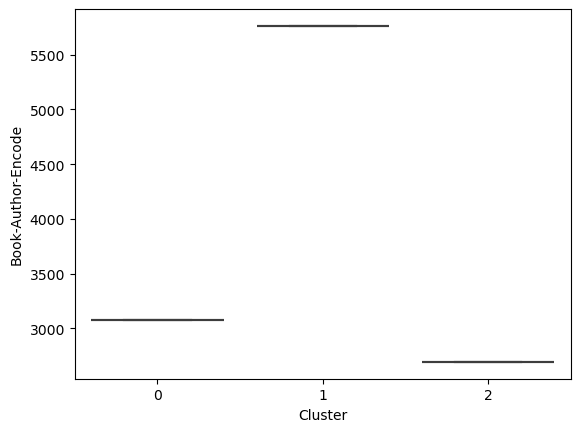

In [9]:
sns.boxplot(x='Cluster', y='Book-Author-Encode', data=cluster_profiles)
plt.show()

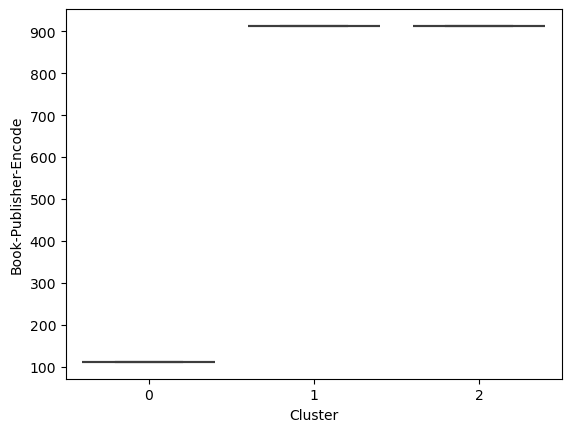

In [10]:
cluster_profiles['Cluster'] = cluster_profiles.index
sns.boxplot(x='Cluster', y='Book-Publisher-Encode', data=cluster_profiles)
plt.show()